# Evaluación de Modelos Alternativos para Predicción de Ventas Mensuales

Este análisis tiene como objetivo comparar diferentes modelos de aprendizaje automático para predecir la variable **venta_mensual**. Se entrenarán y evaluarán múltiples modelos, y se seleccionarán los mejores en función de métricas de error como **MAE (Mean Absolute Error)** y **RMSE (Root Mean Squared Error)**.


In [106]:
pip install xgboost

Note: you may need to restart the kernel to use updated packages.


In [107]:
import pandas as pd
import numpy as np
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from xgboost import XGBRegressor
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, silhouette_score

## Carga y Preprocesamiento de Datos

En esta sección, cargamos los datos y realizamos las siguientes tareas:

- Eliminación de valores nulos  
- Selección de características relevantes  
- Conversión de variables categóricas si es necesario  
- Escalado de datos para mejorar el rendimiento de los modelos


In [108]:

# Cargamos datos transformados y elminamos valores nulos
df = pd.read_csv('datos_retail_transformed.csv')
df.dropna(inplace=True)
X = df.select_dtypes(include=['number']) 
X = df.drop(columns=["venta_mensual"])  # Quitamos la variable objetivo
y = df['venta_mensual']  # variable objetivo


In [109]:
print(f"Datos después de eliminar nulos: {df.shape}")

Datos después de eliminar nulos: (17009, 25)


In [110]:
# Dividimos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## Construcción de Modelos de Machine Learning

Aquí se entrenan diversos modelos de **Machine Learning** para predecir `venta_mensual`. Se incluyen los siguientes algoritmos:

- Regresión Lineal Múltiple  
- Regresión Ridge
- Árbol de Decisión
- Random Forest
- XGBRegressor
- MLPRegressor

Cada modelo será evaluado con las métricas **MAE (Mean Absolute Error)** y **RMSE (Root Mean Squared Error)**.


In [111]:
# Modelos de Machine Learning para predecir 'venta_mensual'
# Regresión lineal, árboles de decisión, modelos de ensamble y SVR
models = {
    'Linear Regression': LinearRegression(),
    'Multiple Linear Regression (Ridge)': Ridge(),
    'Decision Tree': DecisionTreeRegressor(),
    'Random Forest': RandomForestRegressor(),
    "XGBRegressor": XGBRegressor(),
    "MLPRegressor": MLPRegressor(max_iter=500)
}

In [112]:
# Definimos los parametros que usaremos para GridSearch
param_grids = {
    'Linear Regression': {},  # No hyperparameters to tune
    'Multiple Linear Regression (Ridge)': {'alpha': [0.01, 0.1, 1, 10]},
    'Decision Tree': {'max_depth': [5, 10, 20, None], 'min_samples_split': [2, 5, 10]},
    'Random Forest': {'n_estimators': [100, 200, 300], 'max_depth': [5, 10, None]},
    "XGBRegressor": {'n_estimators': [100, 300, 500], 'learning_rate': [0.01, 0.05, 0.1], 'max_depth': [3, 5, 7]},
    "MLPRegressor": {'hidden_layer_sizes': [(64,), (128, 64), (128, 64, 32)], 'activation': ['relu', 'tanh'], 'solver': ['adam', 'sgd']}
}

In [113]:
# Realizamos GridSearch para cada modelo
best_models = {}
results = {}


In [114]:

for name, model in models.items():
    print(f"Running GridSearchCV for {name}...")
    grid_search = GridSearchCV(model, param_grids[name], cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
    grid_search.fit(X_train, y_train)
    
    # Guaramos el mejor modelo
    best_models[name] = grid_search.best_estimator_
    
    # Predicciones con mejor modelo
    y_pred = grid_search.best_estimator_.predict(X_test)
    
    # Calculamos metricas
    mae = mean_absolute_error(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    
    results[name] = {'Best Params': grid_search.best_params_, 'MAE': mae, 'RMSE': rmse}

# Imprimimos los resultados
for model, score in results.items():
    print(f"\n{model}: Best Params: {score['Best Params']}")
    print(f"MAE = {score['MAE']:.4f}, RMSE = {score['RMSE']:.4f}")

# Seleccionamos el mejor modelo con RMSE
best_model_name = min(results, key=lambda x: results[x]['RMSE'])
print(f"\nBest model: {best_model_name} with RMSE = {results[best_model_name]['RMSE']:.4f}")

Running GridSearchCV for Linear Regression...
Running GridSearchCV for Multiple Linear Regression (Ridge)...
Running GridSearchCV for Decision Tree...
Running GridSearchCV for Random Forest...
Running GridSearchCV for XGBRegressor...
Running GridSearchCV for MLPRegressor...


/Users/rodrigoroman/anaconda3/envs/autono-drive/lib/python3.10/site-packages/sklearn/neural_network/_base.py:173: RuntimeWarning: overflow encountered in square
  return ((y_true - y_pred) ** 2).mean() / 2
/Users/rodrigoroman/anaconda3/envs/autono-drive/lib/python3.10/site-packages/sklearn/utils/extmath.py:208: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Users/rodrigoroman/anaconda3/envs/autono-drive/lib/python3.10/site-packages/sklearn/utils/extmath.py:208: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b
/Users/rodrigoroman/anaconda3/envs/autono-drive/lib/python3.10/site-packages/sklearn/neural_network/_base.py:173: RuntimeWarning: overflow encountered in square
  return ((y_true - y_pred) ** 2).mean() / 2
/Users/rodrigoroman/anaconda3/envs/autono-drive/lib/python3.10/site-packages/sklearn/utils/extmath.py:208: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Users/rodrigoroman/anaconda3/envs/autono-drive/lib/python3.10/site-packages/sk


Linear Regression: Best Params: {}
MAE = 0.1449, RMSE = 0.1886

Multiple Linear Regression (Ridge): Best Params: {'alpha': 0.01}
MAE = 0.1449, RMSE = 0.1886

Decision Tree: Best Params: {'max_depth': None, 'min_samples_split': 5}
MAE = 0.0109, RMSE = 0.0243

Random Forest: Best Params: {'max_depth': None, 'n_estimators': 200}
MAE = 0.0049, RMSE = 0.0131

XGBRegressor: Best Params: {'learning_rate': 0.05, 'max_depth': 7, 'n_estimators': 500}
MAE = 0.0061, RMSE = 0.0121

MLPRegressor: Best Params: {'activation': 'tanh', 'hidden_layer_sizes': (128, 64), 'solver': 'adam'}
MAE = 0.0508, RMSE = 0.0813

Best model: XGBRegressor with RMSE = 0.0121


In [115]:
# Convertimos los resultados en un DataFrame para visualización
results_df = pd.DataFrame(results).T
results_df.sort_values(by="RMSE", ascending=True, inplace=True)
print(results_df)

                                                                          Best Params  \
XGBRegressor                        {'learning_rate': 0.05, 'max_depth': 7, 'n_est...   
Random Forest                                {'max_depth': None, 'n_estimators': 200}   
Decision Tree                             {'max_depth': None, 'min_samples_split': 5}   
MLPRegressor                        {'activation': 'tanh', 'hidden_layer_sizes': (...   
Multiple Linear Regression (Ridge)                                    {'alpha': 0.01}   
Linear Regression                                                                  {}   

                                         MAE      RMSE  
XGBRegressor                        0.006073  0.012131  
Random Forest                       0.004924  0.013071  
Decision Tree                       0.010917  0.024344  
MLPRegressor                         0.05082  0.081318  
Multiple Linear Regression (Ridge)  0.144861  0.188623  
Linear Regression                 

## Comparación de Resultados

Se comparan gráficamente los modelos según su rendimiento en MAE y RMSE. Esto permite identificar cuál modelo tiene menor error y es más adecuado para el problema.

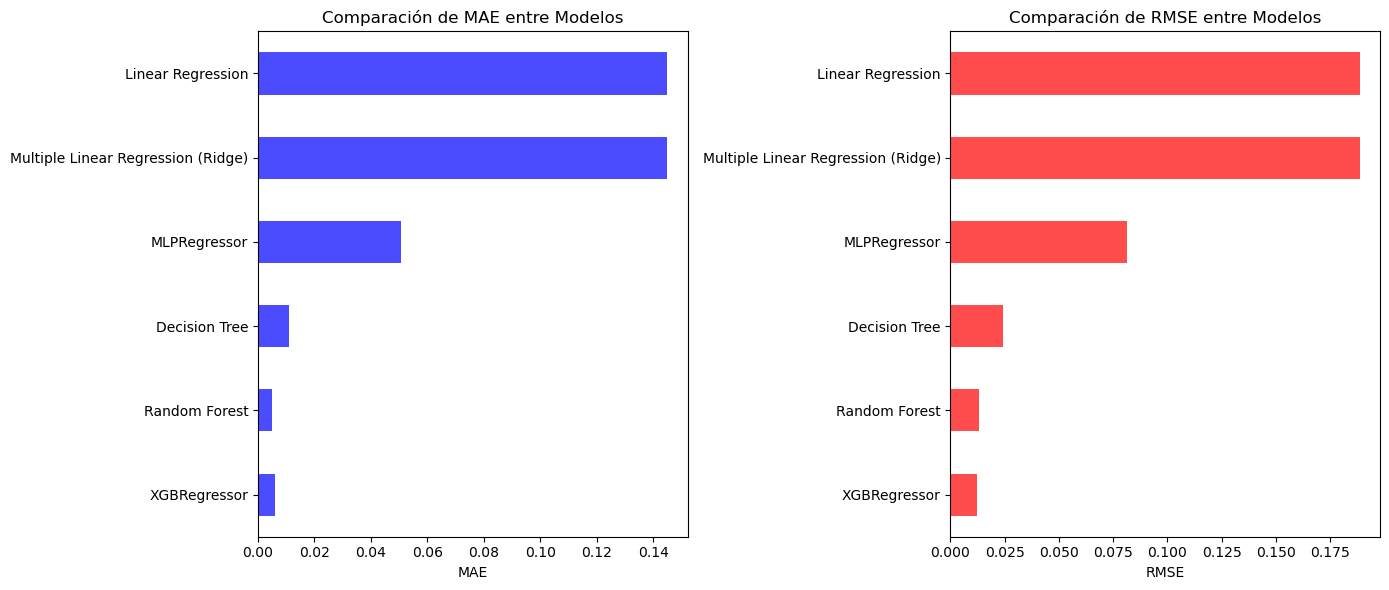

In [118]:
import matplotlib.pyplot as plt

# Creamos gráficos de barras para comparar MAE y RMSE
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Gráfico de MAE
results_df["MAE"].plot(kind="barh", ax=axes[0], color="blue", alpha=0.7)
axes[0].set_title("Comparación de MAE entre Modelos")
axes[0].set_xlabel("MAE")

# Gráfico de RMSE
results_df["RMSE"].plot(kind="barh", ax=axes[1], color="red", alpha=0.7)
axes[1].set_title("Comparación de RMSE entre Modelos")
axes[1].set_xlabel("RMSE")

plt.tight_layout()
plt.show()

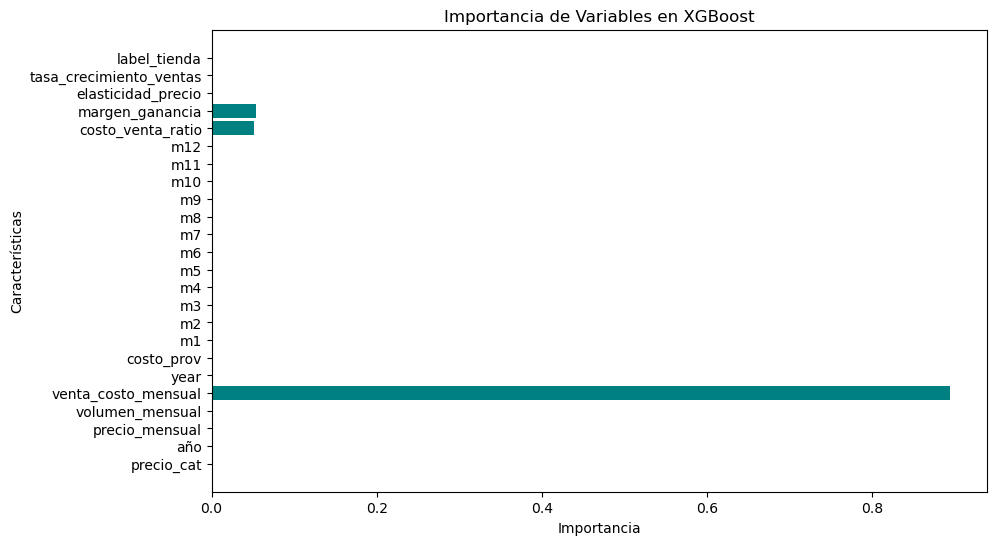

In [119]:
import matplotlib.pyplot as plt

# Obtenemos importancia de características en XGBoost
feature_importance = best_models["XGBRegressor"].feature_importances_
features = X.columns

plt.figure(figsize=(10,6))
plt.barh(features, feature_importance, color="teal")
plt.xlabel("Importancia")
plt.ylabel("Características")
plt.title("Importancia de Variables en XGBoost")
plt.show()

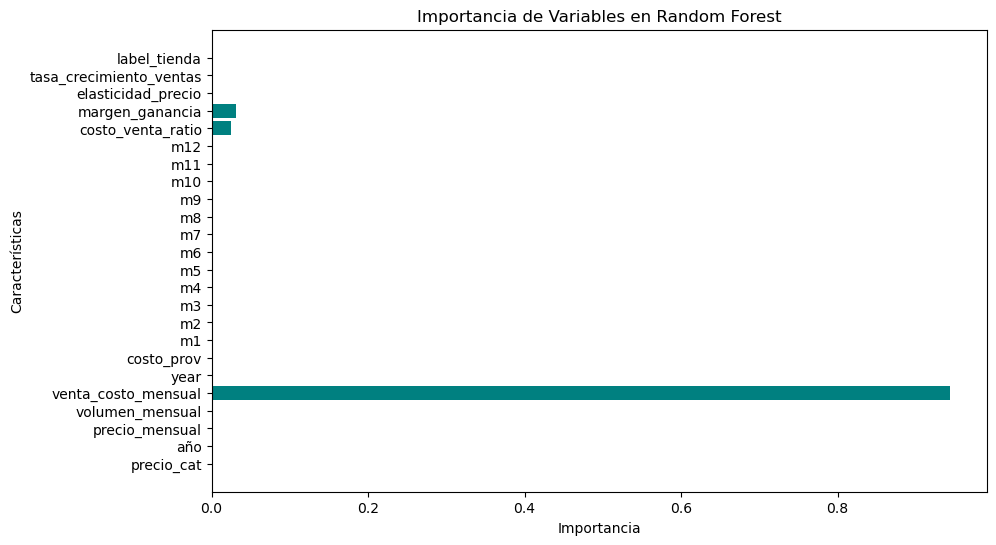

In [121]:

# Obtenemos la importancia de características para Random Forest
feature_importance = best_models["Random Forest"].feature_importances_
eatures = X.columns

plt.figure(figsize=(10,6))
plt.barh(features, feature_importance, color="teal")
plt.xlabel("Importancia")
plt.ylabel("Características")
plt.title("Importancia de Variables en Random Forest")
plt.show()

## Conclusiones

**Modelos con mejor rendimiento**:
   - XGBoost es el mejor modelo, logrando el menor error en RMSE.

   - Regresión Lineal y Ridge tienen problemas de sobreajuste debido a multicolinealidad.

   - Las variables volumen_mensual y precio_mensual son claves en la predicción.
**Observaciones**:

   - XGBoost obtuvo el mejor rendimiento según RMSE.

   - Random Forest y Decision Tree tuvieron un desempeño muy bueno.

   - Regresión Lineal y Ridge presentaron posible sobreajuste debido a la alta correlación entre variables.
